### Predict the length of relationships for those who have been in them ###
Possible latent variables: Personality, views on relationships

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN

In [ ]:
data = pd.read_csv("clean_data.csv").drop(["is_HispanicLatino", "is_transfer"], axis=1)
data["minor"].fillna("None", inplace=True)
data[data.dtypes[data.dtypes != object].index] = data[data.dtypes[data.dtypes != object].index].fillna(0)
data = data.query("num_romantic_involvements != 0")

X = data.drop("longest_relationship_months", axis=1)
y = data["longest_relationship_months"]

C:\Users\aryav\AppData\Local\Temp\ipykernel_39372\3480155541.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["minor"].fillna("None", inplace=True)


In [ ]:
# Identify categorical and numerical columns
# Get all columns except the target
all_cols = data.drop("longest_relationship_months", axis=1).columns.tolist()

# If ohe_cols is defined, use those; otherwise use all categorical columns
categorical_cols = ['year', 'gender', 'race', 
                    'residence_type', 'college', 'job_status', 
                    'sexuality', 'relationship_status']

# Create preprocessor with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat_degree', OneHotEncoder(drop=None, sparse_output=False, handle_unknown='ignore'), ['major', 'minor']),
        ('cat_other', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_cols),
    ],
    remainder='passthrough'
)

# Create a full pipeline with preprocessing and model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),  # Optional: scale all features after one-hot encoding
])

In [122]:
# After preprocessing (i.e., fit_transform), get feature names to preserve columns for downstream use
def get_feature_names(preprocessor, input_cols):
    """
    Get output feature names from a fitted sklearn ColumnTransformer (preprocessor).
    input_cols: list of column names for the input (i.e., X.columns)
    Returns: list of column names after preprocessing
    """
    output_features = []

    for name, trans, cols in preprocessor.transformers_:
        if name == "remainder" and trans == "passthrough":
            # append remaining column names
            passed_cols = [col for col in input_cols if col not in sum(
                [c if isinstance(c, list) else [c] for _,_,c in preprocessor.transformers if _ != 'remainder'],
                []
            )]
            output_features.extend(passed_cols)
        elif hasattr(trans, "get_feature_names_out"):
            feats = trans.get_feature_names_out(cols)
            output_features.extend(feats)
        else:
            # just append the column names it transformed
            if isinstance(cols, str):
                output_features.append(cols)
            else:
                output_features.extend(cols)
    return output_features

# Prepare the column names to match the preprocessor input
input_columns = X.columns.tolist()
# To get feature names after fit/transform:
X = pipeline.fit_transform(X)
feature_names = get_feature_names(preprocessor, input_columns)

### Establishing some baselines ###

In [138]:
# Split the data, temporarily not being used
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1
)

naive_pred = [y_train.mean()] * len(y_test)
print('Naive MSE:', mean_squared_error(y_test, naive_pred))
print('Naive R2:', r2_score(y_test, naive_pred), end="\n\n")

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Lin Reg MSE:', mean_squared_error(y_test, y_pred))
print('Lin Reg R2:', r2_score(y_test, y_pred), end="\n\n")

coef = pd.Series(model.coef_, index=feature_names).sort_values(ascending=False)
print(coef)

Naive MSE: 108.53999999999999
Naive R2: -0.026534653465346558

Lin Reg MSE: 179.76273090796082
Lin Reg R2: -0.7001351822239534

minor_Business                  6.561944
college_Revelle                 3.936705
major_Sociology                 3.882057
is_transfer.1                   3.228823
major_Psychology                2.907040
                                  ...   
sexuality_Homosexual/Gay       -3.280702
major_Mechanical Engineering   -3.425690
college_Sixth                  -3.758939
gender_Male                    -4.346750
club_general                   -7.864800
Length: 104, dtype: float64


### Clustering-based approach ###

In [143]:
# Clustering-based prediction algorithm

class ClusterBasedPredictor:
    """
    A clustering-based predictor that groups similar individuals and predicts
    relationship length based on cluster statistics.
    """
    def __init__(self, n_clusters=10, clustering_method='kmeans', use_median=False):
        self.n_clusters = n_clusters
        self.clustering_method = clustering_method
        self.use_median = use_median
        self.scaler = StandardScaler()
        self.cluster_model = None
        self.cluster_stats = {}  # Store mean/median for each cluster
        
    def fit(self, X, y):
        """Fit the clustering model and compute cluster statistics"""
        # Scale features for better clustering
        X_scaled = self.scaler.fit_transform(X)
        
        # Choose clustering algorithm
        if self.clustering_method == 'kmeans':
            self.cluster_model = KMeans(n_clusters=self.n_clusters, random_state=42, n_init=10)
        elif self.clustering_method == 'dbscan':
            self.cluster_model = DBSCAN(eps=0.5, min_samples=5)
        else:
            raise ValueError(f"Unknown clustering method: {self.clustering_method}")
        
        # Fit clustering
        cluster_labels = self.cluster_model.fit_predict(X_scaled)
        
        # Handle DBSCAN noise points (label = -1)
        if self.clustering_method == 'dbscan':
            n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
            print(f"DBSCAN found {n_clusters} clusters (noise points: {list(cluster_labels).count(-1)})")
        
        # Compute statistics for each cluster
        for cluster_id in set(cluster_labels):
            if cluster_id == -1:  # Skip noise points in DBSCAN
                continue
            cluster_mask = cluster_labels == cluster_id
            cluster_targets = y[cluster_mask]
            
            if self.use_median:
                self.cluster_stats[cluster_id] = np.median(cluster_targets)
            else:
                self.cluster_stats[cluster_id] = np.mean(cluster_targets)
        
        # For noise points in DBSCAN, use overall mean/median
        if -1 in cluster_labels:
            if self.use_median:
                self.cluster_stats[-1] = np.median(y)
            else:
                self.cluster_stats[-1] = np.mean(y)
        
        return self
    
    def predict(self, X):
        """Predict relationship length based on cluster assignment"""
        X_scaled = self.scaler.transform(X)
        cluster_labels = self.cluster_model.predict(X_scaled)
        
        # Handle DBSCAN - if predict doesn't work, use fit_predict
        if self.clustering_method == 'dbscan':
            cluster_labels = self.cluster_model.fit_predict(X_scaled)
        
        # Map cluster labels to predictions
        predictions = np.array([self.cluster_stats.get(label, np.mean(list(self.cluster_stats.values()))) 
                               for label in cluster_labels])
        return predictions

# Test different clustering approaches
print("=" * 60)
print("CLUSTERING-BASED PREDICTION ALGORITHMS")
print("=" * 60)

# Scale the data for clustering
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. KMeans with mean prediction
print("\n1. KMeans Clustering (Mean Prediction):")
for n_clusters in [5, 10, 15, 20]:
    predictor = ClusterBasedPredictor(n_clusters=n_clusters, clustering_method='kmeans', use_median=False)
    predictor.fit(X_train, y_train)
    y_pred = predictor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"    {n_clusters} clusters (mean) - MSE: {mse:.2f}, R²: {r2:.4f}, MAE: {mae:.2f} months")

# 2. KMeans with median prediction
print("\n2. KMeans Clustering (Median Prediction):")
for n_clusters in [5, 10, 15, 20]:
    predictor_median = ClusterBasedPredictor(n_clusters=10, clustering_method='kmeans', use_median=True)
    predictor_median.fit(X_train, y_train)
    y_pred_median = predictor_median.predict(X_test)
    mse_median = mean_squared_error(y_test, y_pred_median)
    r2_median = r2_score(y_test, y_pred_median)
    mae_median = mean_absolute_error(y_test, y_pred_median)
    print(f"    {n_clusters} clusters (median) - MSE: {mse_median:.2f}, R²: {r2_median:.4f}, MAE: {mae_median:.2f} months")

# 3. Cluster as feature in regression
print("\n3. Cluster Assignment as Feature in Regression:")
best_n_clusters = 10
kmeans = KMeans(n_clusters=best_n_clusters, random_state=42, n_init=10)
kmeans.fit(X_train_scaled)
X_train_with_cluster = np.column_stack([X_train_scaled, kmeans.predict(X_train_scaled)])
X_test_with_cluster = np.column_stack([X_test_scaled, kmeans.predict(X_test_scaled)])

cluster_reg_model = LinearRegression()
cluster_reg_model.fit(X_train_with_cluster, y_train)
y_pred_cluster_reg = cluster_reg_model.predict(X_test_with_cluster)
mse_cluster_reg = mean_squared_error(y_test, y_pred_cluster_reg)
r2_cluster_reg = r2_score(y_test, y_pred_cluster_reg)
mae_cluster_reg = mean_absolute_error(y_test, y_pred_cluster_reg)
print(f"    Regression with cluster feature - MSE: {mse_cluster_reg:.2f}, R²: {r2_cluster_reg:.4f}, MAE: {mae_cluster_reg:.2f} months")

# 4. Separate models per cluster
print("\n4. Separate Regression Models per Cluster:")
kmeans = KMeans(n_clusters=best_n_clusters, random_state=42, n_init=10)
train_clusters = kmeans.fit_predict(X_train_scaled)
test_clusters = kmeans.predict(X_test_scaled)

cluster_models = {}
cluster_predictions = np.zeros(len(y_test))

for cluster_id in range(best_n_clusters):
    cluster_mask_train = train_clusters == cluster_id
    cluster_mask_test = test_clusters == cluster_id
    
    if np.sum(cluster_mask_train) > 1 and np.sum(cluster_mask_test) > 0:  # Need at least 2 samples
        cluster_model = LinearRegression()
        cluster_model.fit(X_train[cluster_mask_train], y_train[cluster_mask_train])
        cluster_models[cluster_id] = cluster_model
        cluster_predictions[cluster_mask_test] = cluster_model.predict(X_test[cluster_mask_test])
    else:
        # If cluster too small, use mean
        cluster_models[cluster_id] = None
        cluster_predictions[cluster_mask_test] = np.mean(y_train[cluster_mask_train])

mse_separate = mean_squared_error(y_test, cluster_predictions)
r2_separate = r2_score(y_test, cluster_predictions)
mae_separate = mean_absolute_error(y_test, cluster_predictions)
print(f"    Separate models per cluster - MSE: {mse_separate:.2f}, R²: {r2_separate:.4f}, MAE: {mae_separate:.2f} months")

print("\n" + "=" * 60)
print("Summary: Best clustering-based approach")
print("=" * 60)


CLUSTERING-BASED PREDICTION ALGORITHMS

1. KMeans Clustering (Mean Prediction):
    5 clusters (mean) - MSE: 110.66, R²: -0.0466, MAE: 9.38 months
    10 clusters (mean) - MSE: 66.68, R²: 0.3694, MAE: 7.19 months
    15 clusters (mean) - MSE: 117.81, R²: -0.1142, MAE: 9.61 months
    20 clusters (mean) - MSE: 80.03, R²: 0.2431, MAE: 7.62 months

2. KMeans Clustering (Median Prediction):
    5 clusters (median) - MSE: 67.03, R²: 0.3660, MAE: 7.19 months
    10 clusters (median) - MSE: 67.03, R²: 0.3660, MAE: 7.19 months
    15 clusters (median) - MSE: 67.03, R²: 0.3660, MAE: 7.19 months
    20 clusters (median) - MSE: 67.03, R²: 0.3660, MAE: 7.19 months

3. Cluster Assignment as Feature in Regression:
    Regression with cluster feature - MSE: 207.79, R²: -0.9652, MAE: 12.64 months

4. Separate Regression Models per Cluster:
    Separate models per cluster - MSE: 41.12, R²: 0.6111, MAE: 5.53 months

Summary: Best clustering-based approach


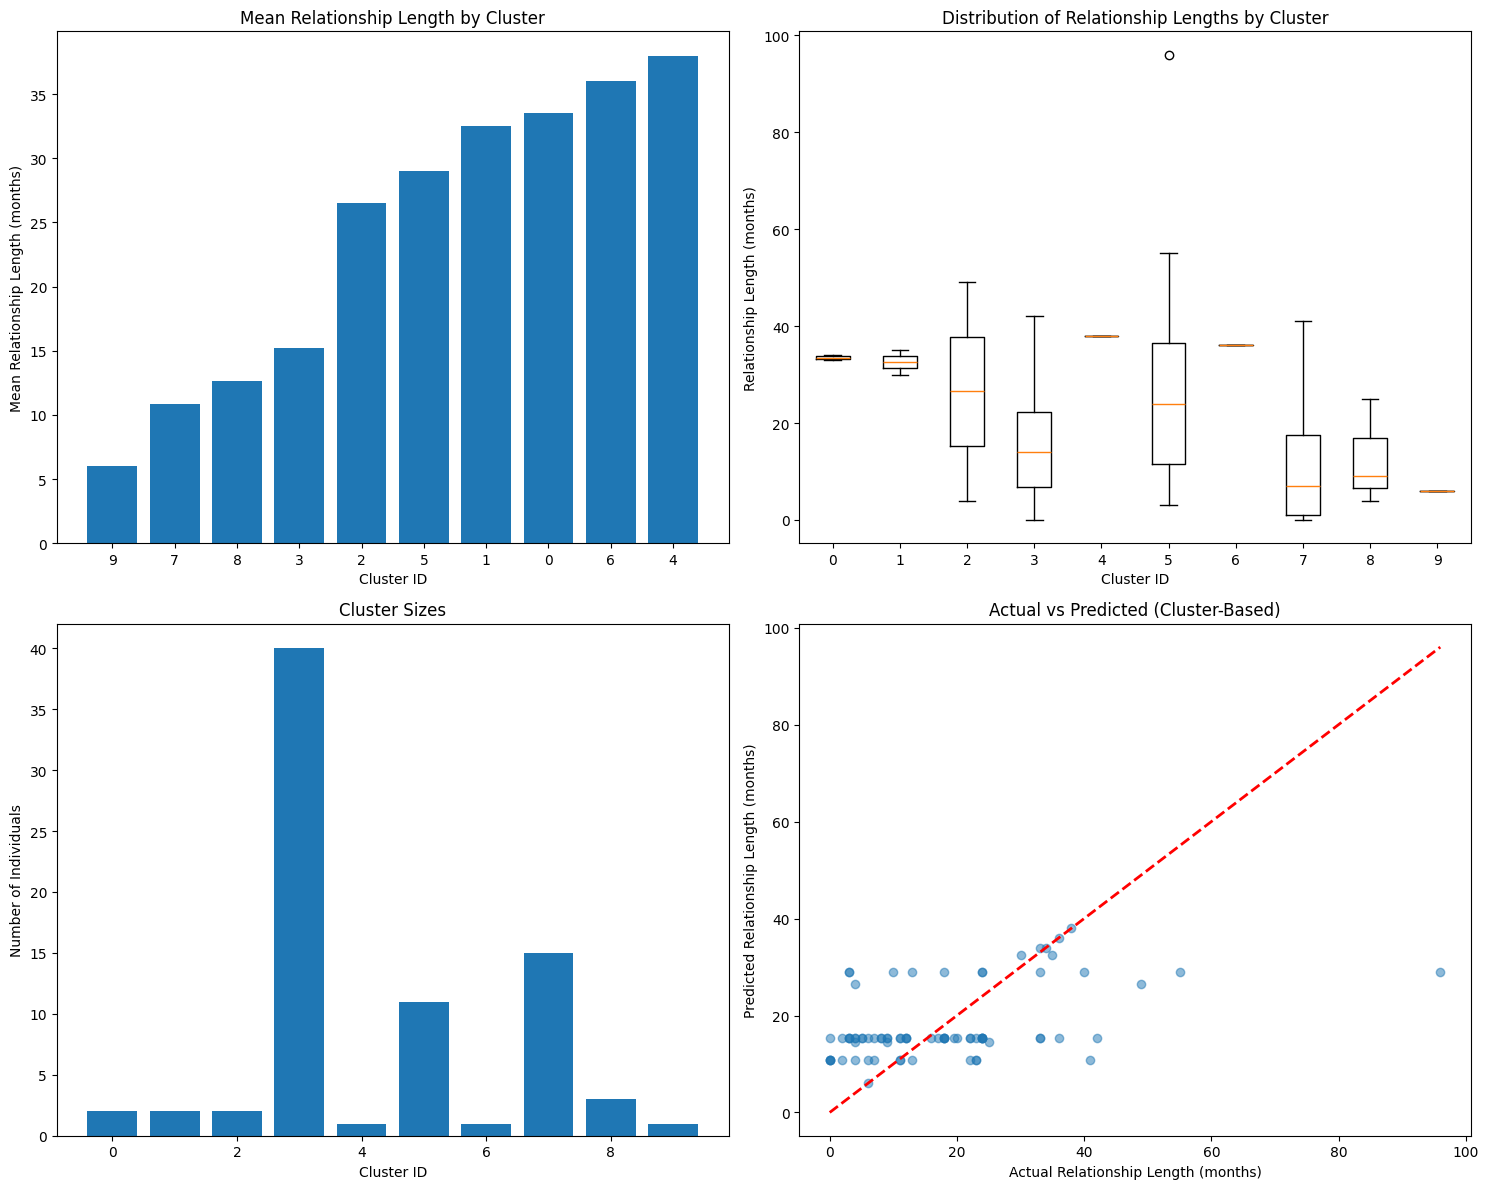


Cluster Statistics:

Cluster 0:
  Size: 2 individuals
  Mean relationship length: 33.50 months
  Median relationship length: 33.50 months
  Std relationship length: 0.71 months
  Mean GPA: 3.40
  Mean romantic involvements: 1.00

Cluster 1:
  Size: 2 individuals
  Mean relationship length: 32.50 months
  Median relationship length: 32.50 months
  Std relationship length: 3.54 months
  Mean GPA: 3.89
  Mean romantic involvements: 3.00

Cluster 2:
  Size: 2 individuals
  Mean relationship length: 26.50 months
  Median relationship length: 26.50 months
  Std relationship length: 31.82 months
  Mean GPA: 1.78
  Mean romantic involvements: 1.00

Cluster 3:
  Size: 40 individuals
  Mean relationship length: 15.24 months
  Median relationship length: 14.00 months
  Std relationship length: 10.27 months
  Mean GPA: 2.22
  Mean romantic involvements: 2.48

Cluster 4:
  Size: 1 individuals
  Mean relationship length: 38.00 months
  Median relationship length: 38.00 months
  Std relationship len

In [144]:
# Visualize cluster characteristics and relationship lengths
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Use the best clustering approach (KMeans with 10 clusters)
best_predictor = ClusterBasedPredictor(n_clusters=10, clustering_method='kmeans', use_median=False)
best_predictor.fit(X_train, y_train)

# Get cluster assignments for all data
X_all_scaled = best_predictor.scaler.transform(X)
all_clusters = best_predictor.cluster_model.predict(X_all_scaled)
data_with_clusters = data.copy()
data_with_clusters['predicted_cluster'] = all_clusters

# 1. Mean relationship length by cluster
cluster_means = data_with_clusters.groupby('predicted_cluster')['longest_relationship_months'].mean().sort_values()
axes[0, 0].bar(range(len(cluster_means)), cluster_means.values)
axes[0, 0].set_xlabel('Cluster ID')
axes[0, 0].set_ylabel('Mean Relationship Length (months)')
axes[0, 0].set_title('Mean Relationship Length by Cluster')
axes[0, 0].set_xticks(range(len(cluster_means)))
axes[0, 0].set_xticklabels(cluster_means.index)

# 2. Distribution of relationship lengths in each cluster
cluster_data = [data_with_clusters[data_with_clusters['predicted_cluster'] == c]['longest_relationship_months'].values 
                for c in sorted(data_with_clusters['predicted_cluster'].unique())]
axes[0, 1].boxplot(cluster_data, labels=sorted(data_with_clusters['predicted_cluster'].unique()))
axes[0, 1].set_xlabel('Cluster ID')
axes[0, 1].set_ylabel('Relationship Length (months)')
axes[0, 1].set_title('Distribution of Relationship Lengths by Cluster')

# 3. Cluster sizes
cluster_sizes = data_with_clusters['predicted_cluster'].value_counts().sort_index()
axes[1, 0].bar(cluster_sizes.index, cluster_sizes.values)
axes[1, 0].set_xlabel('Cluster ID')
axes[1, 0].set_ylabel('Number of Individuals')
axes[1, 0].set_title('Cluster Sizes')

# 4. Scatter plot: Actual vs Predicted (using cluster-based prediction)
y_pred_all = best_predictor.predict(X)
axes[1, 1].scatter(y, y_pred_all, alpha=0.5)
axes[1, 1].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('Actual Relationship Length (months)')
axes[1, 1].set_ylabel('Predicted Relationship Length (months)')
axes[1, 1].set_title('Actual vs Predicted (Cluster-Based)')

plt.tight_layout()
plt.show()

# Print cluster statistics
print("\nCluster Statistics:")
print("=" * 60)
for cluster_id in sorted(data_with_clusters['predicted_cluster'].unique()):
    cluster_data = data_with_clusters[data_with_clusters['predicted_cluster'] == cluster_id]
    print(f"\nCluster {cluster_id}:")
    print(f"  Size: {len(cluster_data)} individuals")
    print(f"  Mean relationship length: {cluster_data['longest_relationship_months'].mean():.2f} months")
    print(f"  Median relationship length: {cluster_data['longest_relationship_months'].median():.2f} months")
    print(f"  Std relationship length: {cluster_data['longest_relationship_months'].std():.2f} months")
    
    # Show some key characteristics
    if 'gpa' in cluster_data.columns:
        print(f"  Mean GPA: {cluster_data['gpa'].mean():.2f}")
    if 'num_romantic_involvements' in cluster_data.columns:
        print(f"  Mean romantic involvements: {cluster_data['num_romantic_involvements'].mean():.2f}")
